In [23]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
path_to_data="C:\DSP\PlantVillage"

In [25]:
import os
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [26]:
img_dirs

['C:\\DSP\\PlantVillage\\Pepper__bell___Bacterial_spot',
 'C:\\DSP\\PlantVillage\\Pepper__bell___healthy']

In [27]:
import numpy as np
import pywt
import cv2

def w2d(img,mode='haar',level=1):
    imArray=img
    imArray=cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    imArray=np.float32(imArray)
    imArray/=225
    
    coeffs=pywt.wavedec2(imArray,mode,level=level)
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0
    
    
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)
    
    return imArray_H

In [28]:
image_dirs=[]
plant_file_names_dict={}


for img_dir in img_dirs:
    count=1
    plant_name=img_dir.split('\\')[-1]
    plant_file_names_dict[plant_name]=[]
    for entry in os.scandir(img_dir):
        
        image=cv2.imread(entry.path)
        if image is not None:
            folder=path_to_data + plant_name
            if not os.path.exists(folder):
                os.makedirs(folder)
                image_dirs.append(folder)
                print("generating wd images in folder",folder)
                
            file_name=plant_name+str(count)+".png"
            file_path=folder+"/"+file_name
            cv2.imwrite(file_path,image)
            plant_file_names_dict[plant_name].append(file_path)
            count=count+1

In [29]:
plant_file_names_dict

{'Pepper__bell___Bacterial_spot': ['C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot1.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot2.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot3.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot4.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot5.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot6.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot7.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot8.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot9.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pepper__bell___Bacterial_spot10.png',
  'C:\\DSP\\PlantVillagePepper__bell___Bacterial_spot/Pe

In [30]:
class_dict={}
count=0
for plant_name in plant_file_names_dict.keys():
    class_dict[plant_name]=count
    count+=1
class_dict

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}

In [31]:
x=[]
y=[]

for plant_name,training_files in plant_file_names_dict.items():
    for training_image in training_files:
        img=cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img=cv2.resize(img,(64,64))
        img_har=w2d(img,'db1',5)
        scalled_img_har=cv2.resize(img_har,(64,64))
#         combined_img=np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        combined_img=scalled_img_har.reshape(64*64,1)
        x.append(combined_img)
        y.append(class_dict[plant_name])
        

In [32]:
scalled_img_har=cv2.resize(img_har,(64,64))
len(scalled_img_har.reshape(64*64,1))

4096

In [33]:
x[0].shape

(4096, 1)

In [34]:
x=np.array(x).reshape(len(x),4096).astype(float)
x.shape

(2475, 4096)

In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [36]:
X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=0)
pipe=Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])

               
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)
               

0.8126009693053312

In [37]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75       257
           1       0.80      0.90      0.85       362

    accuracy                           0.81       619
   macro avg       0.82      0.79      0.80       619
weighted avg       0.82      0.81      0.81       619



In [38]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [39]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pipe.predict(X_test))
cm

array([[176,  81],
       [ 35, 327]], dtype=int64)

Text(69.0, 0.5, 'true')

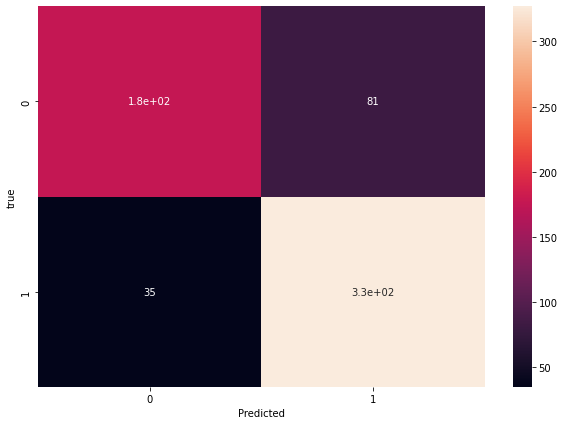

In [40]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('true')

In [42]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    
   
    
}

In [43]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
print("Best hyperparameters and Best scores using Grid Search")
df

Best hyperparameters and Best scores using Grid Search


model  best_score                                   best_params
0            svm    0.768335          {'svc__C': 10, 'svc__kernel': 'rbf'}
1  random_forest    0.615832  {'randomforestclassifier__n_estimators': 10}

In [44]:
best_estimators['svm'].score(X_test,y_test)

0.8126009693053312

In [45]:
best_clf=best_estimators['svm']

In [46]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,best_clf.predict(X_test))
cm

array([[176,  81],
       [ 35, 327]], dtype=int64)

Text(69.0, 0.5, 'true')

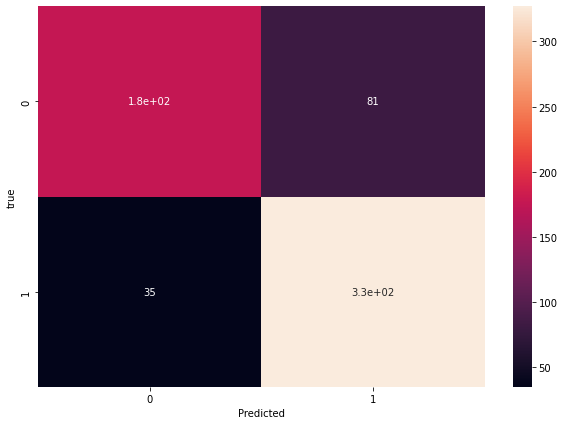

In [47]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('true')